In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import urllib.request, json
import os

from math import sqrt
from sklearn.metrics import mean_squared_error
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

### 1.1. Load the Data

In [29]:
df=pd.read_csv('../data/us_disaster_declarations.csv')

### 1.2. Clean States

In [30]:
# Clean states / remove territories 
mainland_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
                   "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
                   "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
                   "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
                   "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

df=df[df['state'].isin(mainland_states)]

### 1.3. Clean / Combine Incident Types

In [36]:
# List incident types to drop
disaster_drops=['Biological', 'Chemical', 'Fishing Losses', 'Human Cause', 'Other', 'Terrorist', 'Toxic Substances']

# Drop specified incident types
for d in disaster_drops:
    df=df[df.incident_type != d]

In [41]:
# List incident types to combine
winter_weather=['Severe Ice Storm', 'Snowstorm', 'Freezing', 'Winter Storm']

# Combine specified incidents into incident type 'winter weather'
for w in winter_weather:
    df.loc[df['incident_type'] == w, 'incident_type'] = 'Winter Weather'

#result = df[df['incident_type'] == 'Winter Weather']
#print(result)

### 1.4. Date Encoding

In [38]:
# Create 'incident_dtm' column to convert 'incident_begin_date' obj to datetime
df['incident_dtm']=pd.to_datetime(df['incident_begin_date'], format='%Y-%m-%dT%H:%M:%SZ')

### 1.5. Clean Columns

In [40]:
# Remove unneeded columns

# Create subset_df with 'incident_dtm', 'incident_type', and 'state'
subset_df=df[['incident_dtm', 'incident_type', 'state']]

subset_df.set_index('incident_dtm', inplace=True)

subset_df.head()

,incident_type,state
incident_dtm,,
1953-05-02,Tornado,GA
1953-05-15,Tornado,TX
1953-05-29,Flood,LA
1953-06-02,Tornado,MI
1953-06-06,Flood,MT


### 2.1. ARIMA Test

/tmp/ipykernel_529/3410975933.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = subset_df.resample('M').size()


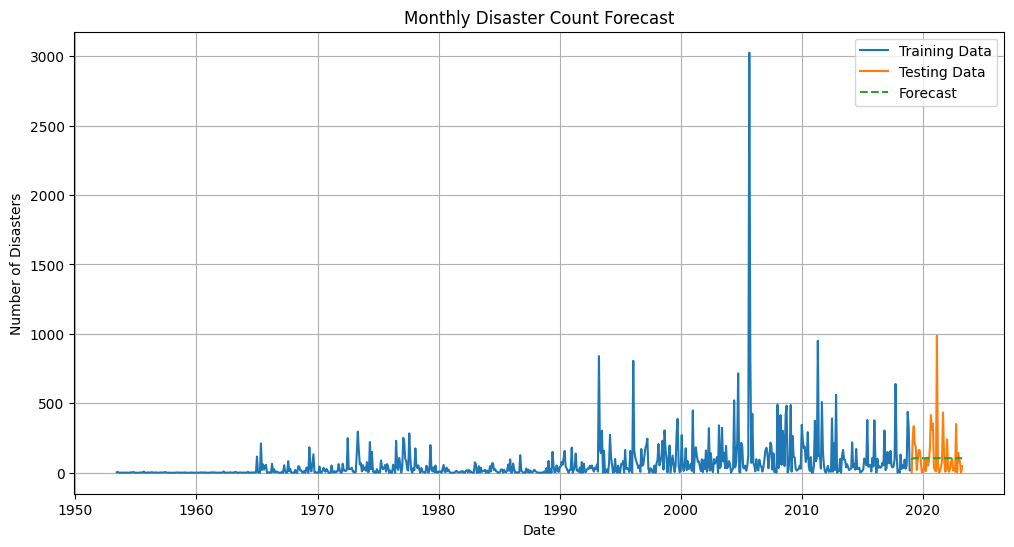

Root Mean Squared Error: 169.46941538905145


In [42]:
# Monthly aggregation and "no disaster" feature
monthly_disasters = subset_df.resample('M').size()
monthly_disasters_df = monthly_disasters.to_frame(name='disaster_count')
monthly_disasters_df['no_disaster'] = monthly_disasters_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)

# Train-test split
split_date = '2019-01-01'
train = monthly_disasters_df[:split_date]['disaster_count']
test = monthly_disasters_df[split_date:]['disaster_count']

# ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Monthly Disaster Count Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Disasters')
plt.legend()
plt.grid()
plt.show()

# Evaluate model
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")

### 2.2. MultiOutputClassifier Test